In [8]:
#%pip install numpy matplotlib zarr xarray ipykernel gcsfs fsspec dask cartopy ocf-blosc2 torchinfo
#%pip install -U doxa-cli

**Importing packages**

Here, we import a number of packages we will need to train our first model.

In [1]:
import os
from datetime import datetime, time, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
from ocf_blosc2 import Blosc2
from torch.utils.data import DataLoader, IterableDataset
from torchinfo import summary
import json
# import geopandas as gpd
import seaborn as sns
from scipy.ndimage import zoom
import numpy as np
import h5py

plt.rcParams["figure.figsize"] = (20, 12)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [11]:
# if not os.path.exists("submission"):
#      os.makedirs("submission", exist_ok=True)
#      #Installing locally means you do not need to rerun this each time you restart the notebook
#      !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/competition.py --output submission/competition.py
#      !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/doxa.yaml --output submission/doxa.yaml
#      !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/model.py --output submission/model.py
#      !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/run.py --output submission/run.py
#      !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/indices.json --output indices.json
# if not os.path.exists("data"):
#     os.makedirs("data/pv/2020", exist_ok=True)
#     os.makedirs("data/satellite-hrv/2020", exist_ok=True)

#     !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/pv/metadata.csv --output data/pv/metadata.csv
#     !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/pv/2020/7.parquet --output data/pv/2020/7.parquet
#     !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/satellite-hrv/2020/7.zarr.zip --output data/satellite-hrv/2020/7.zarr.zip


pv = pd.read_parquet("data/pv/2020/7.parquet").drop("generation_wh", axis=1)
#The parquet data here is similar to a dataframe. The "power" is the column with the other data types being indexes. The data is shaped with each timestamp being its own sub frame with the sites having their corresponding power (I think this is the % of their total possible yield).  
hrv = xr.open_dataset(
    "data/satellite-hrv/2020/7.zarr.zip", engine="zarr", chunks="auto"
)
#The way that this works is that it stores the image as a vector. The vectors are stored as an array of vectors. These then have a timestamp, as we only have one channel the array is a 1D set of vectors with the dimension being time. Read this to help you understand how this is being stored https://tutorial.xarray.dev/fundamentals/01_datastructures.html
# To access I have included some examples below
#The float value (float16-float64) shows the precision with which data is stored. Later on it is important to make sure that when you are feeding in data into the model that the float type matches between data types, this currently is not a problem when only using the HRV data. I am not yet sure if this will be a problem when using the NWP data.

with open("indices.json") as f:
    site_locations = {
        data_source: {
            int(site): (int(location[0]), int(location[1]))
            for site, location in locations.items()
        }
        for data_source, locations in json.load(f).items()
    }

In [4]:
hrv["data"] #This stores all of the data within this channel as a 16 bit set of floats with 47 chunks. The cube on the side shows how the each image is stored.

<xarray.DataArray 'data' (time: 6721, y_geostationary: 592,
                          x_geostationary: 684, channel: 1)> Size: 5GB
dask.array<open_dataset-data, shape=(6721, 592, 684, 1), dtype=float16, chunksize=(165, 592, 684, 1), chunktype=numpy.ndarray>
Coordinates:
  * channel          (channel) <U3 12B 'HRV'
  * time             (time) datetime64[ns] 54kB 2020-07-01T04:00:00 ... 2020-...
  * x_geostationary  (x_geostationary) float64 5kB -1.089e+06 ... -4.061e+05
  * y_geostationary  (y_geostationary) float64 5kB 4.449e+06 ... 5.04e+06
Attributes: (12/38)
    HRV__satpy_id:                              !!python/object/apply:satpy.d...
    HRV_ancillary_variables:                    []
    HRV_area:                                   msg_seviri_rss_1km:\n  descri...
    HRV_calibration:                            reflectance
    HRV_end_time:                               2020-01-01T00:00:07.676580
    HRV_georef_offset_corrected:                True
    ...                                         ...
    standard_name:                              toa_bidirectional_reflectance
    start_time:                                 2019-12-31T23:55:07.772388
    sun_earth_distance_correction_applied:      True
    sun_earth_distance_correction_factor:       0.9666341924425861
    units:                                      %
    wavelength:                                 [0.5, 0.7, 0.9, 'µm']

In [13]:
print(hrv["time"][0])
print(hrv["time"][-1])
#There seems to be some discrepancy with the time dimensions beyond the resolution. Multiplying out the nwp dataset to 12x its size shows that there is some mismatch in the datasets, I am not sure why yet. 

<xarray.DataArray 'time' ()> Size: 8B
array('2020-07-01T04:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2020-07-01T04:00:00
<xarray.DataArray 'time' ()> Size: 8B
array('2020-07-31T22:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2020-07-31T22:00:00


**Creates the dataloader object that feeds data to the model; this needs to be changed if we want to pass in non-hrv data**

In [21]:
#This function extracts the area around each individual site using the PV pixel based dictionary (as in the location of sites are determined by their pixel in the image) location and then extracts an area around each site. These areas are combined, based on their timestamp,
#with the HRV data that then has its satellite imagery data extracted. This implies that the model is using subsets of the satellite imagery to train the model to make predictions for each site rather than using the whole image and then "learning" where the sites are.

class ChallengeDataset(IterableDataset): # PyTorch 'Dataset' style class
    def __init__(self, pv, hrv, site_locations, start_date = "2020-7-1", end_date = "2020-7-30", sites=None): # The "self" augmentation here is used to use create a shared class between the different data types that are then iterable based on their shared timestamp
        self.pv = pv
        self.hrv = hrv
        self._site_locations = site_locations
        self._sites = sites if sites else list(site_locations["hrv"].keys())#This gets the individual site ids which are stored as the dict's keys
        self.start_date = list(map(int, start_date.split("-")))
        self.end_date= list(map(int, end_date.split("-")))

    #This function starts at the minimum date in the set and iterates up to the highest date; done as the data set is large and due to the nature of the parquette and xarray
    def _get_image_times(self):
        min_date = datetime(self.start_date[0], self.start_date[1], self.start_date[2])
        max_date = datetime(self.end_date[0], self.end_date[1], self.end_date[2])
        # max and min need to be changed if we use more than one month of data
        
        start_time = time(8)
        end_time = time(17)

        date = min_date #starts at the first timestamp
        while date <= max_date: #iterates through up to the max
            current_time = datetime.combine(date, start_time)
            while current_time.time() < end_time:
                if current_time:
                    yield current_time

                current_time += timedelta(minutes=60)

            date += timedelta(days=1)

    def __iter__(self):
        for time in self._get_image_times():
            first_hour = slice(str(time), str(time + timedelta(minutes=55)))#gets the time and then uses this to select the corresponding time from the pv set  

            pv_features = pv.xs(first_hour, drop_level=False)  # this gets the pv yield of the current timestamp selected earlier
            pv_targets = pv.xs(
                slice(  # type: ignore
                    str(time + timedelta(hours=1)),
                    str(time + timedelta(hours=4, minutes=55)),
                ),
                drop_level=False,
            ) # pv targets defines the time span over which we are trying to make pv yield predictions

            hrv_data = self.hrv["data"].sel(time=first_hour).to_numpy()#gets the hrv satellite image that is associated with the first hour timestamp setting it up as an input feature

            for site in self._sites:
                try:
                    # Get solar PV features and targets, the site_targets is used to find the models loss
                    site_features = pv_features.xs(site, level=1).to_numpy().squeeze(-1)#gets the pixel based location of the pv site and then uses this to make predictions based on the individual sites
                    site_targets = pv_targets.xs(site, level=1).to_numpy().squeeze(-1)
                    assert site_features.shape == (12,) and site_targets.shape == (48,)#compresses the data from N dimensions to 12 and 48 respectively

                    # Get a 128x128 HRV crop centred on the site over the previous hour
                    x, y = self._site_locations["hrv"][site]#gets the location of the site based on the pv sites pixel level location
                    hrv_features = hrv_data[:, y - 64 : y + 64, x - 64 : x + 64, 0]
                    assert hrv_features.shape == (12, 128, 128)#crops the image to be be 128x128 around the site
                    #asset is used to force the dimensions of the extracted site level image to be the same
                    # How might you adapt this for the non-HRV, weather and aerosol data?
                except:
                    continue

                yield site_features, hrv_features, site_targets

**comments are the same and this does not work yet**

Here I am including the nwp data into the dataloader using the resampled clch data (resampled only on pixel dimensions), we need to figure out a way to overcome the time resolution conflict.

In [ ]:
#This function extracts the area around each individual site using the PV dicts pixel based (as in the location of sites are determined by their pixel in the image) location and then extracts an area around each site. These areas are combined, based on their timestamp,
#with the HRV data that then has its satellite imagery data extracted. This implies that the model is using subsets of the satellite imagery to train the model to make predictions for each site rather than using the whole image and then "learning" where the sites are.

#Note the IterableDataset here inherits properties from the library it is attached to
class ChallengeDataset_nwp(IterableDataset):#This function sets up the data so that it can be iterated through by the CNN
    def __init__(self, pv, hrv, knn_nwp, site_locations, sites=None):#The "self" augmentation here is used to use create a shared class between the different data types that are then iterable based on their shared timestamp
        self.pv = pv
        self.hrv = hrv
        self.knn_nwp = knn_nwp#adding the nwp xarray 
        self._site_locations = site_locations
        self._sites = sites if sites else list(site_locations["hrv"].keys())#This gets the individual site ids which are stored as the dict's keys

    def _get_image_times(self):#This function starts at the minimum date in the set and iterates up to the highest date, this is done as the data set is large and due to the nature of the parquette and xarray
        min_date = datetime(2020, 7, 1)
        max_date = datetime(2020, 7, 2) #I have changed this to see if the model works
        #max and min need to be changed if we use more than one month of data
        start_time = time(8)
        end_time = time(17)

        date = min_date#starts at the first timestamp
        while date <= max_date: #iterates through up to the max
            current_time = datetime.combine(date, start_time)
            while current_time.time() < end_time:
                if current_time:
                    yield current_time

                current_time += timedelta(minutes=60)

            date += timedelta(days=1)

    def __iter__(self):
        for time in self._get_image_times():
            first_hour = slice(str(time), str(time + timedelta(minutes=55)))#gets the time and then uses this to select the corresponding time from the pv set  

            pv_features = pv.xs(first_hour, drop_level=False)  # this gets the pv yield of the current timestamp selected earlier
            pv_targets = pv.xs(
                slice(  # type: ignore
                    str(time + timedelta(hours=1)),
                    str(time + timedelta(hours=4, minutes=55)),
                ),
                drop_level=False,
            )#pv targets defines the time span over which we are trying to make pv yield predictions

            hrv_data = self.hrv["data"].sel(time=first_hour).to_numpy()#gets the hrv satellite image that is associated with the first hour timestamp setting it up as an input feature
            
            knn_nwp_data = self.knn_nwp.sel(time=first_hour).to_numpy()
            
            for site in self._sites:
                try:
                    # Get solar PV features and targets
                    site_features = pv_features.xs(site, level=1).to_numpy().squeeze(-1)#gets the pixel based location of the pv site and then uses this to make predictions based on the individual sites
                    site_targets = pv_targets.xs(site, level=1).to_numpy().squeeze(-1)
                    combined_features = np.concatenate((hrv_features, nwp_features), axis=-1)
                    assert site_features.shape == (12,)
                    assert site_targets.shape == (48,)
                    assert combined_features.shape[1:] == (12, 128, 128) #compresses the data from N dimensions to 12 and 48 respectively

                    # Get a 128x128 HRV crop centred on the site over the previous hour
                    x, y = self._site_locations["hrv"][site]#gets the location of the site based on the pv sites pixel level location
                    hrv_features = hrv_data[:, y - 64 : y + 64, x - 64 : x + 64, 0]
                    nwp_features = knn_nwp_data[:, y - 64 : y + 64, x - 64 : x + 64]
                    assert combined_features.shape == (12, 128, 128)#crops the image to be be 128x128 around the site
                    #asset is used to force the dimensions of the extracted site level image to be the same
                    # How might you adapt this for the non-HRV, weather and aerosol data?
                except:
                    continue

                yield site_features, combined_features, site_targets

Creating a schematic for the articecture of whatever CNN/CNNs we use should be done for the final submission 


In [13]:
#This model takes the inputs of the PV data and the HRV data to make predictions for the pv based on the HRV feature data.
#This step dictates what the actual shape of the CNN is i.e how many layers, what type of connections they have, and how what the kernel size is. 
# We can load in models here from our github repo and work on them seperately, we will need to be mindfull of the fact that changing the model may require us the change the way in which we test and train them.
#
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #sets up four convolutional layers which have increasingly large output channels
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3)#nn. is part of the pytorch model
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=96, out_channels=192, kernel_size=3)
        #Setting up the pooling layer that reduces the conv layers dimensions, we can tweak this to reduce the computational load by changing the kernel size.
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()#creates a 1D tensor (matrix) that can then be passed to the fully connected layer

        self.linear1 = nn.Linear(6924, 48)

    def forward(self, pv, hrv):#takes the inputs of the pb and the hrv data using Relu activation functions
        x = torch.relu(self.pool(self.conv1(hrv)))#passes the hrv data through the convolutional layers defined before by defining it as x.
        x = torch.relu(self.pool(self.conv2(x)))
        x = torch.relu(self.pool(self.conv3(x)))
        x = torch.relu(self.pool(self.conv4(x)))

        x = self.flatten(x)
        x = torch.concat((x, pv), dim=-1) # uses the shared dimension to combine the flattened layers (time is the shared dimension?)

        x = torch.sigmoid(self.linear1(x))#uses this to then make predictions (as the activation function is sigmoid is the model just trying to predict if the site is outputting power or not?)

        return x

**Summarises the model created above, used to sense check that the data we are passing through is correct and shows the overall structure of the model**

In [14]:
summary(Model(), input_size=[(1, 12), (1, 12, 128, 128)])#Use this to see what your model looks like before running it
#The input size here is used to prime the model summary with the input dimensions it should be expecting.
#Here we have the pv data first (1,12) it has a univariate dimension for each site with 12 dimensions per hour.
#Next we have the hrv data for each site, I think this is done as 1 observation 12 times an hour, with 128 x 128 dimension vector for the image.

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 48]                   --
├─Conv2d: 1-1                            [1, 24, 126, 126]         2,616
├─MaxPool2d: 1-2                         [1, 24, 63, 63]           --
├─Conv2d: 1-3                            [1, 48, 61, 61]           10,416
├─MaxPool2d: 1-4                         [1, 48, 30, 30]           --
├─Conv2d: 1-5                            [1, 96, 28, 28]           41,568
├─MaxPool2d: 1-6                         [1, 96, 14, 14]           --
├─Conv2d: 1-7                            [1, 192, 12, 12]          166,080
├─MaxPool2d: 1-8                         [1, 192, 6, 6]            --
├─Flatten: 1-9                           [1, 6912]                 --
├─Linear: 1-10                           [1, 48]                   332,400
Total params: 553,080
Trainable params: 553,080
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 137.13
Input size (MB): 0.7

## Training models
This generates weights for the model that we can then use for validation. The weights are then saved as the model submission meaning that each time we generate weights we can then save the weights along with the associated model.

In [22]:
#the number of sites per batch
BATCH_SIZE = 32 

#load the data based on the previously defined functions above, the above functions can be altered to change how the data is ingested
train_dataset = ChallengeDataset(pv, hrv, site_locations=site_locations,
                                 start_date="2020-7-1", end_date="2020-7-30")  # controls which data is loaded in
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True)

validation_dataset = ChallengeDataset(pv, hrv, site_locations=site_locations,
                                      start_date="2020-7-31", end_date="2020-7-31") 
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, pin_memory=True)  # controls which data is loaded in

In [23]:
model = Model().to(device)

criterion = nn.L1Loss() # Defining the loss function as MAE
optimiser = optim.Adam(model.parameters(), lr=1e-3) # Defining the optimiser as ADAM 

In [29]:
def model_validation(model, criterion, validation_dataloader):
    model.eval() # This is used to set the model to evaluation mode
    with torch.no_grad(): # This is used to stop the model from storing gradients
        losses = []
        for pv_features, hrv_features, pv_targets in validation_dataloader:
            pv_features, hrv_features, pv_targets = pv_features.to(device, dtype=torch.float), hrv_features.to(device, dtype=torch.float), pv_targets.to(device, dtype=torch.float)
            predictions = model(pv_features, hrv_features)
            loss = criterion(predictions, pv_targets)
            losses.append(loss.item())

    model.train() # This is used to set the model back to training mode
    
    return sum(losses) / len(losses)

In [37]:
EPOCHS = 1
training_losses = []
validation_losses = []
epoch_train_losses = []
epoch_validation_losses = []

for epoch in range(EPOCHS):
    model.train()

    running_loss = 0.0 # resets the running loss after each epoch
    count = 0 # cumulative sites evaluated throughout training

    for i, (pv_features, hrv_features, pv_targets) in enumerate(train_dataloader): 
        optimiser.zero_grad() # resets gradient calculated from previous batch (otherwise it would accumulate in the backward() step)

        pv_features, hrv_features, pv_targets = pv_features.to(device, dtype=torch.float), hrv_features.to(device, dtype=torch.float), pv_targets.to(device, dtype=torch.float) # sends data to the CPU/GPU

        predictions = model(pv_features, hrv_features) # makes predictions for current batch of sites 

        loss = criterion(predictions, pv_targets) # calculates loss between prediction and target (generation)
        loss.backward() # backpropogates the loss

        optimiser.step() # updates parameters based on loss
                
        size = int(pv_targets.size(0)) # number of sites in batch
        running_loss += float(loss) * size
        count += size

        #prints the training and validation loss every 200 batches
        if i % 200 == 199:
            print(f"Epoch {epoch + 1}, Batch {i + 1}:")

            batch_loss = running_loss / count
            training_losses.append(batch_loss)
            print(f"     Training Loss: {batch_loss}")

            validation_loss = model_validation(model, criterion, validation_dataloader)
            validation_losses.append(validation_loss)
            print(f"     Validation Loss: {validation_loss}\n")

    
    epoch_train_loss = running_loss / count
    epoch_train_losses.append(epoch_train_loss)  

    print(f"Epoch {epoch + 1}: {running_loss / count}")
    

Epoch 1, Batch 200:
     Training Loss: 0.1279529646411538
     Validation Loss: 0.22181357522932893

Epoch 1, Batch 400:
     Training Loss: 0.13485849391203375
     Validation Loss: 0.17500761960052016

Epoch 1, Batch 600:
     Training Loss: 0.12176194480930766
     Validation Loss: 0.1838235888693832

Epoch 1, Batch 800:
     Training Loss: 0.10774523746338673
     Validation Loss: 0.17624455945104614

Epoch 1, Batch 1000:
     Training Loss: 0.10908134023938328
     Validation Loss: 0.2750445249944161

Epoch 1, Batch 1200:
     Training Loss: 0.11367479551195478
     Validation Loss: 0.1869161032203935



: 

In [ ]:
torch.save(model.state_dict(), "models/model_1.pt")

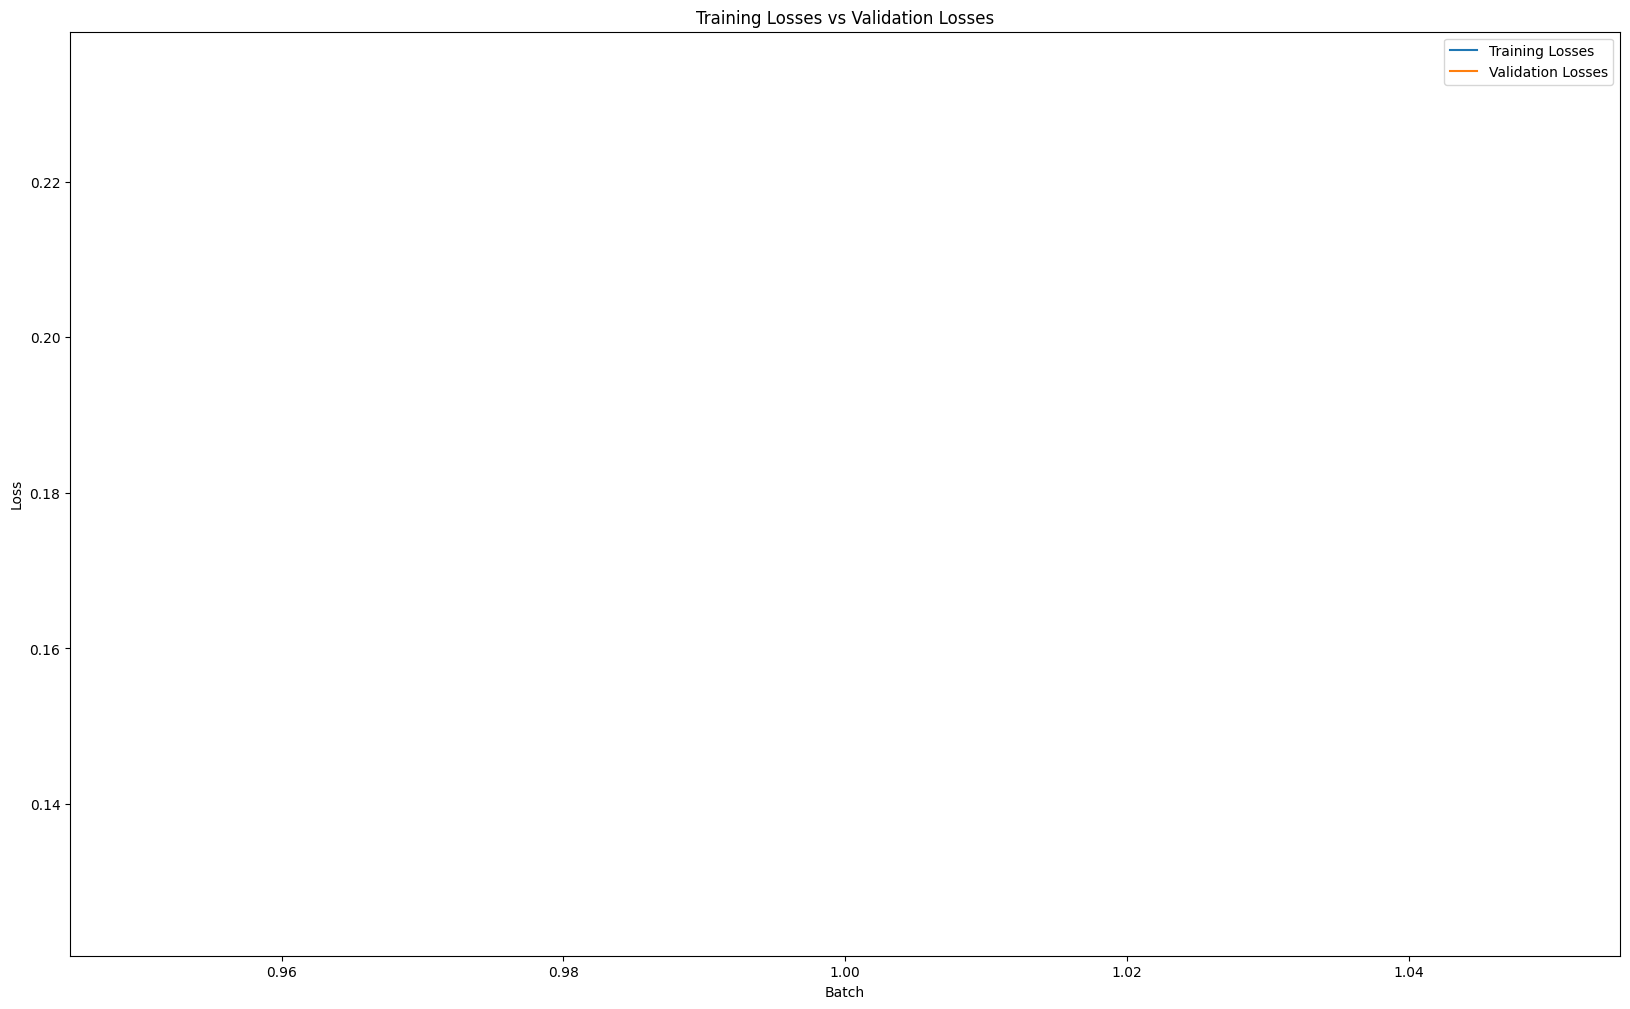

In [36]:
x = [200*i for i in range(len(training_losses))]


# Plotting batch losses
plt.plot(len(batch_losses), batch_losses, label='Training Losses')

# Plotting validation losses
plt.plot(len(batch_losses), validation_losses, label='Validation Losses')

# Adding labels and title
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Losses vs Validation Losses')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()




----

# NWP model

Importing and treating the nwp data, this downloads quickly so no need to download locally

In [ ]:
nwp = xr.open_dataset(
    "zip:///::https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/weather/2020/7.zarr.zip",
    engine="zarr",
    consolidated=True,
)
# note that this only covers one month in this download
nwp

: 

In [7]:
#here I am attempting to resample the nwp data using K-nearest neighbours so that the size of the images match

If you want to resample different channels then simply change the channel selected in the square brackets' just make sure that you change what you're saving it as

In [ ]:
clch_data = nwp["clch"].values  # This extracts the numpy array from the xarray DataArray
target_height = len(hrv["y_geostationary"])  # y dimension from HRV
target_width = len(hrv["x_geostationary"]) 
# Calculate the resampling scale factors assuming you know the desired output dimensions
# For example, if your HRV data is twice as high resolution in both dimensions:
scale_y = target_height / clch_data.shape[1]
scale_x = target_width / clch_data.shape[2]

# Perform nearest-neighbor upscaling, this is quick.
resampled_clch = np.array([zoom(clch_data_slice, (scale_y, scale_x), order=0) for clch_data_slice in clch_data])


In [ ]:
#here I am recreating the xarray that contains the nwp data with the resampled infrared imagery 
lat_values = nwp["latitude"].values
lon_values = nwp["longitude"].values

new_lat = np.linspace(start=lat_values[0], stop=lat_values[-1], num=len(hrv["y_geostationary"]))
new_lon = np.linspace(start=lon_values[0], stop=lon_values[-1], num=len(hrv["x_geostationary"]))

knn_nwp = xr.DataArray(
    data=resampled_clch,
    dims=["time", "latitude", "longitude"],
    coords={
        "time": nwp["time"].values,
        "latitude": new_lat,
        "longitude": new_lon,
    },
    name="clch"#change this to match the channel
)

knn_nwp.attrs = nwp.attrs
knn_nwp.isel(time=9).plot()#cross checking this against the same time for the nwp xarray shows that the dataset has been correctly remade
plt.show()

This is for the model that uses nwp data

In [ ]:
BATCH_SIZE = 32
#these are used to load in the data based on the previously defined functions above, the above functions can be altered to change how the data is ingested
dataset_nwp = ChallengeDataset_nwp(pv, hrv, knn_nwp, site_locations=site_locations)
dataloader_nwp = DataLoader(dataset_nwp, batch_size=BATCH_SIZE, pin_memory=True)#change this to alter which type of data is being loaded in
#note no need to change the DataLoader as that is a pytorch function

NWP model training

In [ ]:
EPOCHS = 1

for epoch in range(EPOCHS):
    model.train()

    running_loss = 0.0##sets the starting loss at zero
    count = 0#sets the count value for iterating to start at the zeroth point (I think this is the zeroth time slice taken earlier)
    for i, (pv_features, hrv_features, pv_targets) in enumerate(dataloader_nwp): 
        optimiser.zero_grad()#resets the gradient of all the previous weights and biases used in the model, can be changed to alter the type of optimiser we use

        predictions = model(
            pv_features.to(device, dtype=torch.float),
            hrv_features.to(device, dtype=torch.float),
        )#makes predictions based off of current batch of hrv and pv inputs

        loss = criterion(predictions, pv_targets.to(device, dtype=torch.float))#calculates the loss between the models predictions and the actual pv
        loss.backward()#backprops the loss

        optimiser.step()#updates the parameters based on the calculated loss

        size = int(pv_targets.size(0))#calculates the size of the first dimension of the pv_targets tensor  to determine how many data points are in the current tensor
        running_loss += float(loss) * size
        count += size
        #prints the current training loss for the first 200 data points, then prints again once the next 200 have been computed
        if i % 200 == 199:
            print(f"Epoch {epoch + 1}, {i + 1}: {running_loss / count}")

    print(f"Epoch {epoch + 1}: {running_loss / count}")